In [1]:
from __future__ import print_function, division
import datetime
import time
import numpy as np
import pandas as pd
import amipy
import quant_iq as iq
from quant_iq import ZeroHedge


class Context(object):
    ''' backtest context '''
    def __init__(self):
        self.symbol = ''
        self.dbase = 'LCAP500'
        self.starting_equity = 1000000.00  #*** per symbol ***#
        self.margin_required = 0
        self.tick_size = 0.01
        self.tick_value = 0.01
        self.risk = 1.
        self.warmup_bars = 500
        self.commission = 0.005  #*** per share ***#

In [2]:
ptimer = time.time()
START_DATE = datetime.datetime(2007, 5, 1)
END_DATE = datetime.datetime(2016, 12, 31)

OBJ = Context()

STRAT = ZeroHedge(OBJ)

portfolio, margin, imp_equity = STRAT.Run(START_DATE, END_DATE)

print('Backtest finished in ' + str(time.time()-ptimer) + ' seconds.\n')

   Backtest finished in 84.94094395637512 seconds.



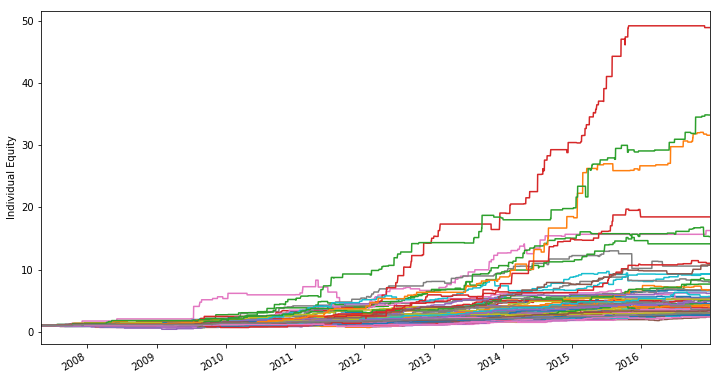

In [3]:
portfolio.iloc[0] = OBJ.starting_equity
portfolio1 = portfolio.fillna(method='ffill').fillna(method='bfill')
amipy._plot(portfolio1/portfolio1.iloc[0], ylabel='Individual Equity', legend=False)

In [4]:
mars = margin.fillna(value=0)
tot = mars.sum(axis=1).resample('1D').last().dropna()
tot.name = 'marg'

imp_equity = imp_equity.fillna(method='ffill').fillna(method='bfill')
ieqt = imp_equity.sum(axis=1).resample('1D').last().dropna()
ieqt.name = 'ieqt'
borrowed = tot - ieqt
interest = borrowed[borrowed>0] * 0.03/365
intr = pd.Series(interest, index=portfolio1.index, name='Interest').fillna(value=0)

intercum = intr.cumsum()

portfolio1 = portfolio1.join(pd.Series(-intercum, index=portfolio1.index, name='Interest').fillna(value=0))

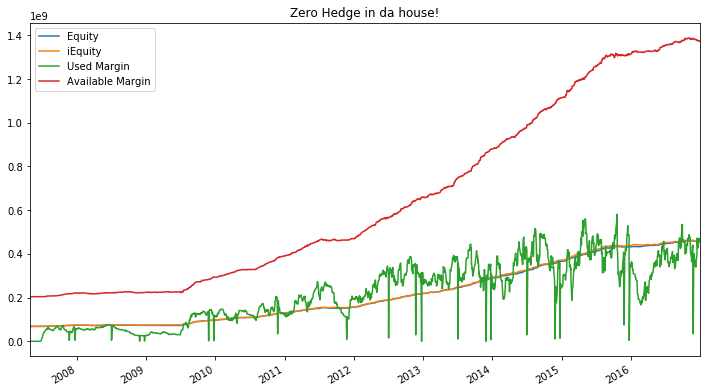

In [5]:
eqt = portfolio1.sum(axis=1)
ptotal = pd.DataFrame(eqt, index=eqt.index)
ptotal = ptotal.join(ieqt)
rel_margin = ptotal.join(tot)
rel_margin.columns = ['Equity', 'iEquity', 'Used Margin']
rel_margin = rel_margin.join(pd.Series(rel_margin.iEquity*3, name='Available Margin'))
amipy._plot(rel_margin, legend=True, title='Zero Hedge in da house!')



Stats for Total from 2007-05-01 00:00:00 - 2016-12-30 00:00:00
Annual risk-free rate considered: 0.25%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
574.46%             6.26  21.83%  -2.86%

Annualized Returns:
mtd    3m     6m     ytd    1y     3y      5y      10y     incep.
-----  -----  -----  -----  -----  ------  ------  ------  --------
0.10%  0.59%  2.87%  6.06%  6.06%  16.59%  24.11%  21.83%  21.83%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  6.26     3.36       1.69
mean    19.81%   20.25%     23.25%
vol     3.12%    5.95%      13.65%
skew    4.66     1.12       -0.71
kurt    60.12    3.03       -0.51
best    3.78%    8.49%      40.27%
worst   -0.81%   -2.03%     -0.66%

Drawdowns:
max       max # days  avg       avg # days
------  ------------  ------  ------------
-2.86%           369  -0.10%          7.16

Misc:
---------------  ------
avg. up month    2.03%
avg. down

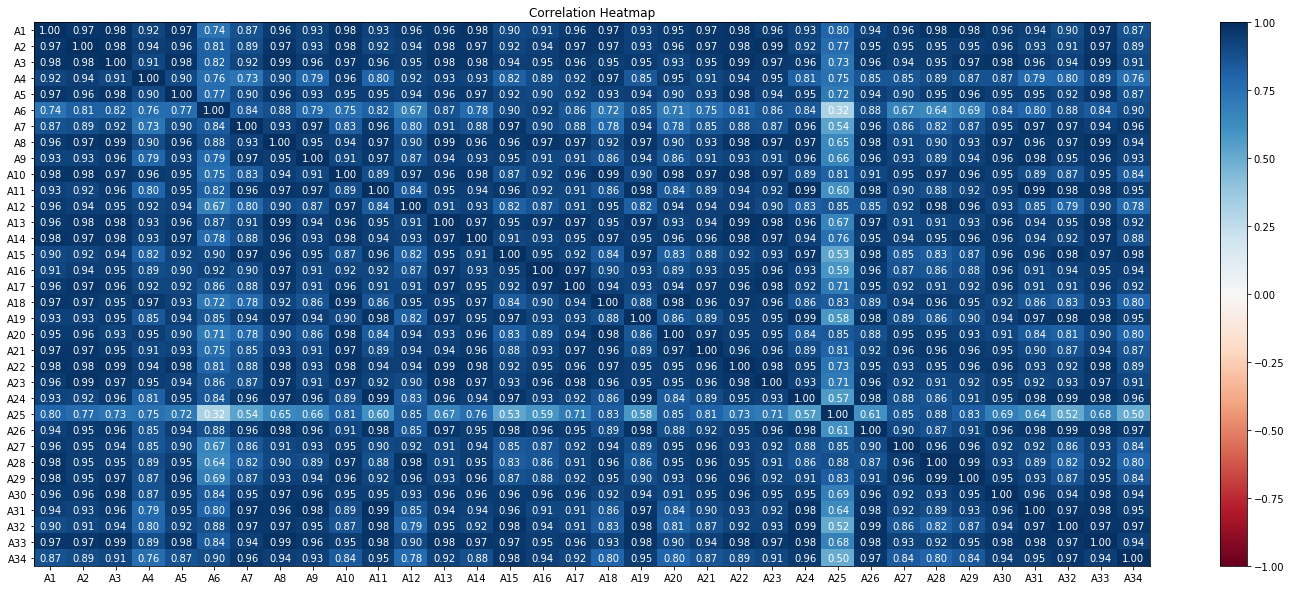

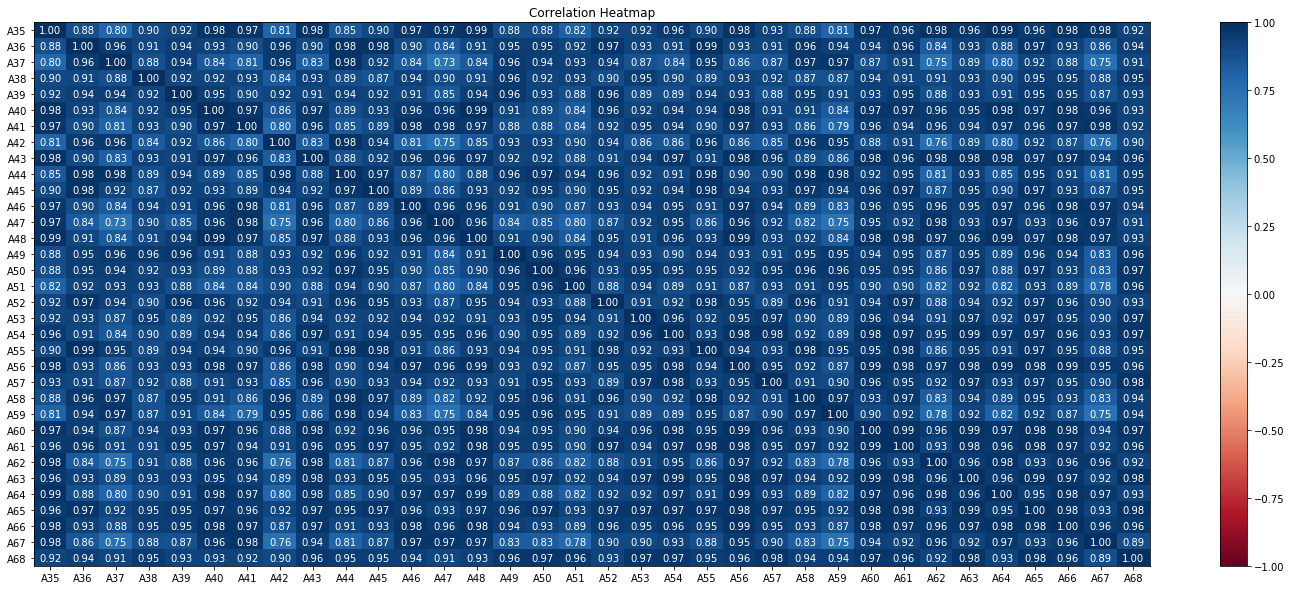

In [6]:
amipy.analyze_portfolio_ffn(portfolio1, 0.0025)

SPY = iq.mongo_grab('SPY', 'YAHOO', START_DATE, END_DATE)
portfolio2 = pd.DataFrame(index=SPY.index)
spdrs = ['XLY', 'XLK', 'XLV', 'XLP']
for spdr in spdrs:
    data = iq.mongo_grab(spdr, 'YAHOO', START_DATE, END_DATE)
    portfolio2 = portfolio2.join(data)


amipy.analyze_portfolio(portfolio1, 0.0025, False)
del portfolio1['Interest']

print('\n vs 4 sector [XLK, XLP, XLV, XLY] buy and hold portfolio')
amipy.analyze_portfolio(portfolio2, 0.0025, False)

ptwo = portfolio1/portfolio1.iloc[0]
ptwo.columns = ['A'+str(x) for x in range(1, len(ptwo.columns)+1)]
fhalf = ptwo.iloc[:, :34]
shalf = ptwo.iloc[:, 34:]
fheat = fhalf.plot_corr_heatmap(title='Correlation Heatmap', figsize=(25,10))
sheat = shalf.plot_corr_heatmap(title='Correlation Heatmap', figsize=(25,10))

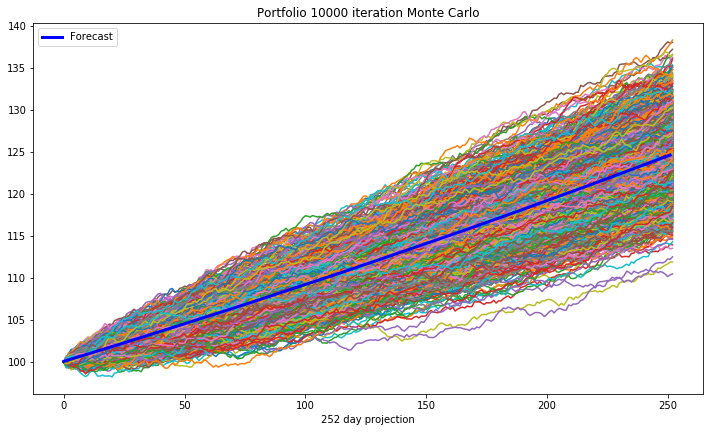

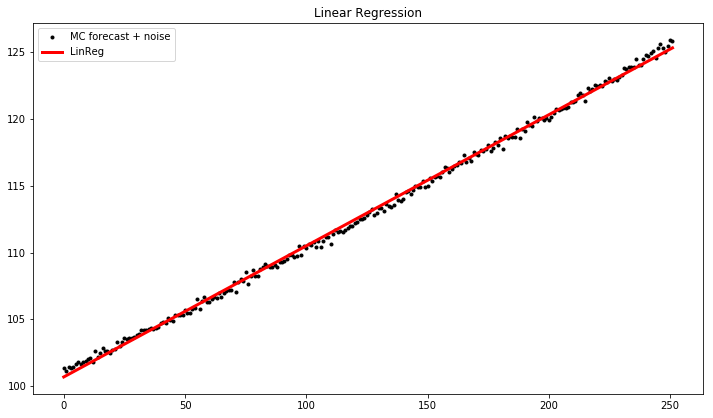

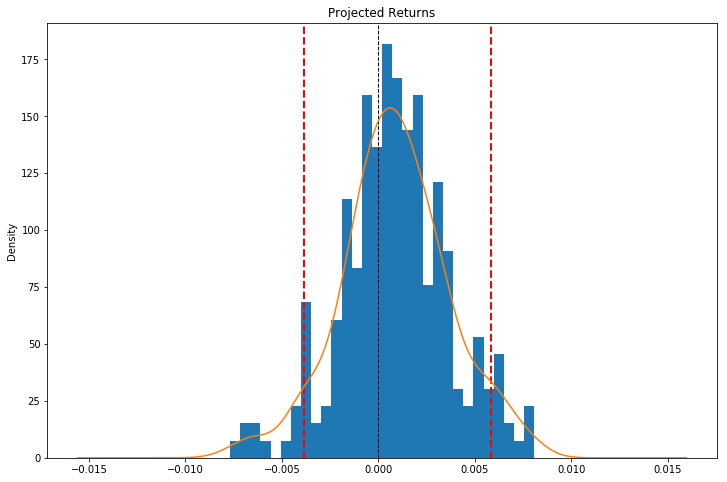

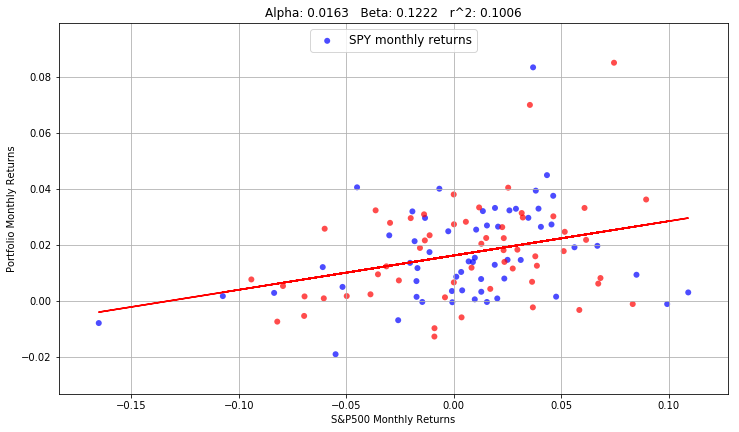

Portfolio stats - Beta: 0.1222  Alpha: 0.0163 

                            OLS Regression Results                            
Dep. Variable:              Portfolio   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     12.64
Date:                Thu, 02 Nov 2017   Prob (F-statistic):           0.000553
Time:                        21:06:02   Log-Likelihood:                 310.56
No. Observations:                 115   AIC:                            -617.1
Df Residuals:                     113   BIC:                            -611.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

In [7]:
from forecast import MonteCarlo, RegOLS
from sklearn.linear_model import LinearRegression

portfolio = portfolio.fillna(method='ffill').fillna(method='bfill')
portfolio['Total'] = portfolio.sum(axis=1)
series = portfolio['Total']
series.name = 'Portfolio'

steps = 10000
MMC = MonteCarlo(steps, plot=True)

stats = MMC.Run(series)
###########################################################################
df = portfolio[:][['Total']].join(SPY)
df.columns = ['Portfolio', 'SPY']
dfm = df.resample('M').last()
returns = dfm.pct_change().dropna()

OLS = RegOLS()
OLS.regress(returns)
#verify OLS
lr = LinearRegression()
_df = np.asarray(returns)
X, y = _df[:, 1:], _df[:, 0]
lr.fit(X, y)
print('Portfolio stats - Beta: %.4f  Alpha: %.4f \n' % (lr.coef_, lr.intercept_))
print(OLS.model.summary())

In [8]:
# I'm a hobo with a dog, I'm a cat with a crown, I'm a bouncer at the velvet ropes...
# You are obsessed! Come over, we can do shots and play Jenga. ;-)

# Look, Wall St. is a door, and you and I are standing in front of it.
# I got the lock picks in my hand, but I can't reach the keyhole
# You're like - "Give me the picks!"
# I'm like - "You don't know how to pick locks!"
# You are asking me to hand you the keys to Wall Street!
# I spent ten years in freaking hell cutting those with a freaking "laser".

# You know how I know you don't know how to pick locks?
# Cause Humpty Dumpty sat on a wall
# Humpty Dumpty took a great fall
# And all of his majesties men
# Cannot put the Humpty
# Cannot put the Dumpty
# On Wall St again
# He's got deep trauma and tissue damage
# Who let him up there with no safety rope?

# And I know for sure you can't code, so ...
# The only way we get to open that door is,
# you pick me up from the muddy puddle I'm standing in
# and put me up on your shoulders, so I can reach the keyhole

# You want to put young Soros back in the saddle, that's fine.
# I heard he's in shambles...
# I got just the thing for him, it's called zero hedge ;-)
# Cause in a state of mind he's in, exposure to risk is not recommended by physicians
# I could live without the risk myself quite frankly ))
# I'm not in a rush, take your time, wisdom don't get stale...
# You know my man the Coop @ 23x Broadway
# Holla at him when you're ready to deal me an ace on the turn!
# 
# https://www.youtube.com/watch?v=vEl3rFjiPgw